# **Modeling and Evaluation**

## Objectives

This notebook addresses **Business Requirement 2** by developing a **classification model** that determines whether a given cherry leaf is infected with **powdery mildew**.

The approach involves:
- Deep Learning-Based Classification: Using a CNN model trained on preprocessed image data.
- Data Augmentation: Enhancing generalization based on variability insights from the Data Visualization Notebook.
- Feature Selection & Analysis: Leveraging PCA and t-SNE to confirm feature separability.
- Hyperparameter Tuning: Using GridSearchCV and cross-validation for optimization.
- Model Evaluation & Explainability: Assessing accuracy, precision, recall, F1-score, and using Grad-CAM & occlusion sensitivity for interpretability.

## Inputs

Dataset Directories:

- inputs/mildew_dataset_dataset/cherry-leaves/train
- inputs/mildew_dataset_dataset/cherry-leaves/test
- inputs/mildew_dataset_dataset/cherry-leaves/validation

Precomputed Features (from Data Visualization Notebook):
- Image Shape Embeddings → Standardized to 128x128x3 for model consistency.
- Class Distribution Insights → Confirmed dataset balance across train, validation, and test sets.
- Feature Space Analysis → PCA and t-SNE confirm strong class separability.
- Pixel Intensity Distribution → Brightness variations provide useful classification features.

## Outputs

- Visualizations & Preprocessing
    - Image Distribution Plot → Confirms class balance in dataset.
	- Augmentation Visualization → Shows the impact of real-time transformations on training data.

- Model Training & Optimization
	- CNN Model with Regularization → Designed to prevent overfitting.
	- Hyperparameter Tuning with GridSearchCV → Finds the best configuration.
	- Best Model Selection → Based on cross-validation performance.
	- Saved Trained Model → Ready for future inference and deployment.

- Evaluation & Interpretability
	- Learning Curve Plot → Illustrates training progression over epochs.
	- Classification Report (Accuracy, Precision, Recall, F1-score) → Provides detailed performance metrics.
	- Confusion Matrix Visualization → Highlights classification strengths & weaknesses.
	- Grad-CAM & Occlusion Sensitivity Analysis → Explains model predictions visually.


## Additional Comments

- Business Impact: This notebook produces a robust mildew detection model for real-time classification.
- Data-Driven Enhancements: Adjustments to augmentation, preprocessing, and model tuning are guided by insights from Data Visualization Notebook.
- Deployment-Ready: The trained model is optimized for integration into a Streamlit application, ensuring real-world usability.


---

## Set Up Environment

### Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detection-app')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection-app'

## Data Loading & Preprocessing

### Set Input Directories

In [5]:
# Set train, validation and test paths
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'


### Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels

In [7]:
# Set the lables for the images
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Healthy', 'Infected']


### Load Precomputed Image Shape from Data Visualization Notebook

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

### Count Images in Each Dataset Split

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


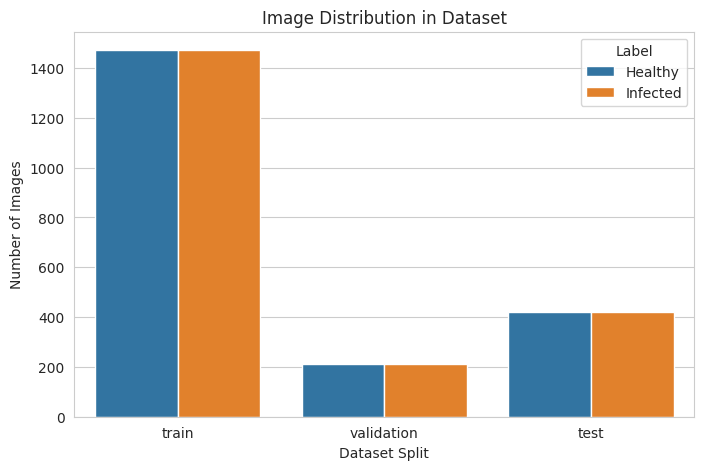

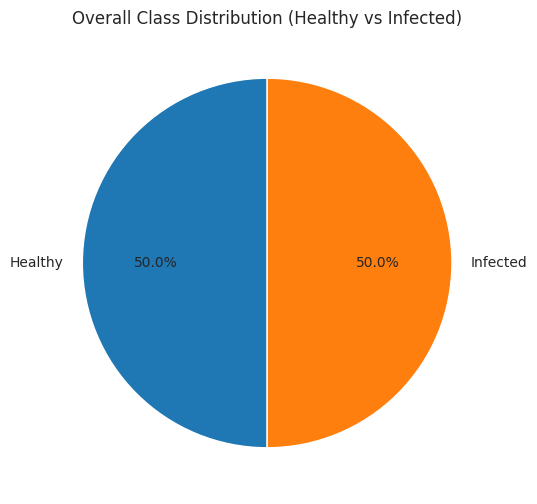

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  # Handle missing directories
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

# ** Bar Chart - Image Distribution**
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

# ** Pie Chart - Class Distribution**
plt.figure(figsize=(6, 6))
label_distribution = df_freq.groupby("Label")["Frequency"].sum()
plt.pie(label_distribution, labels=label_distribution.index, autopct='%1.1f%%', startangle=90, colors=["#1f77b4", "#ff7f0e"])
plt.title("Overall Class Distribution (Healthy vs Infected)")
plt.savefig(f'{file_path}/labels_pie_chart.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Implement Data Augmentation

In [10]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-02-09 21:31:33.836192: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 21:31:33.866649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Initialize ImageDataGenerator for Data Augmentation

In [11]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment Training Image Dataset

In [12]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

### Augment Validation Image Dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

### Augment Test Image Dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

### Visualization of Augmented Images

Plot augmented training image

(20, 128, 128, 3)


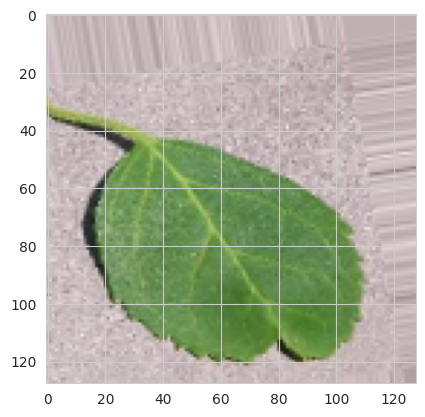

(20, 128, 128, 3)


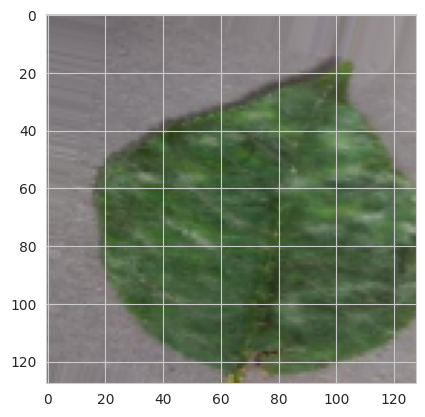

(20, 128, 128, 3)


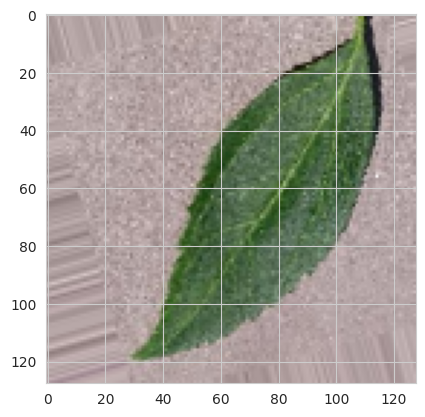

In [15]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation and test images

(20, 128, 128, 3)


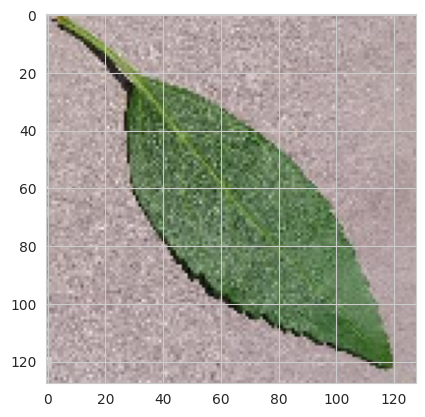

(20, 128, 128, 3)


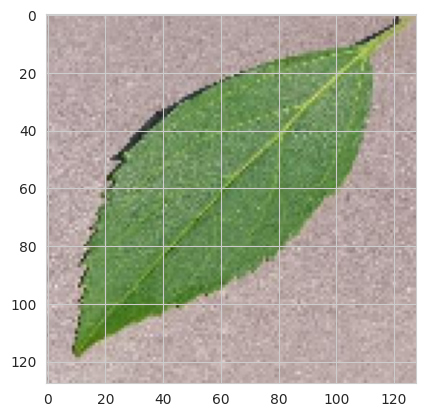

(20, 128, 128, 3)


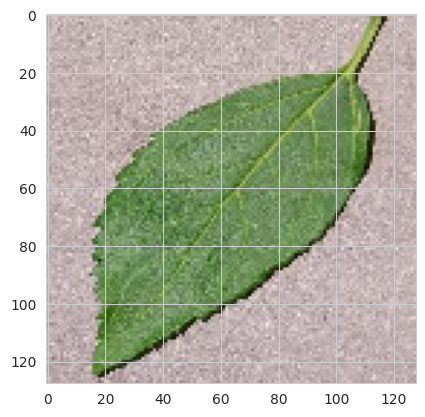

In [16]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 128, 128, 3)


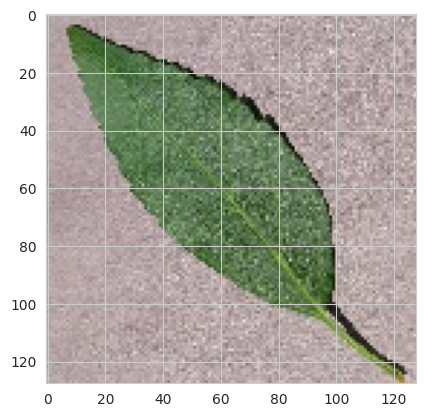

(20, 128, 128, 3)


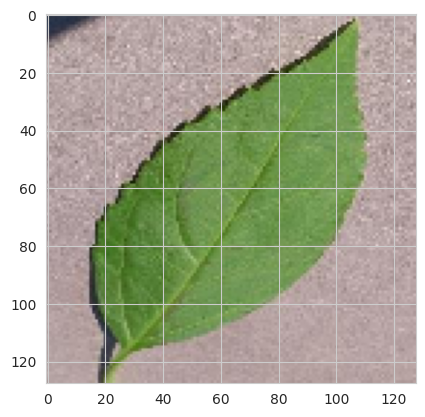

(20, 128, 128, 3)


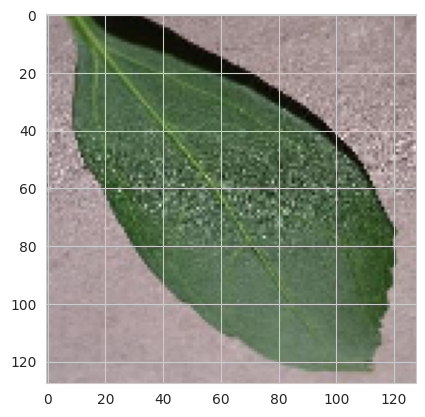

In [17]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

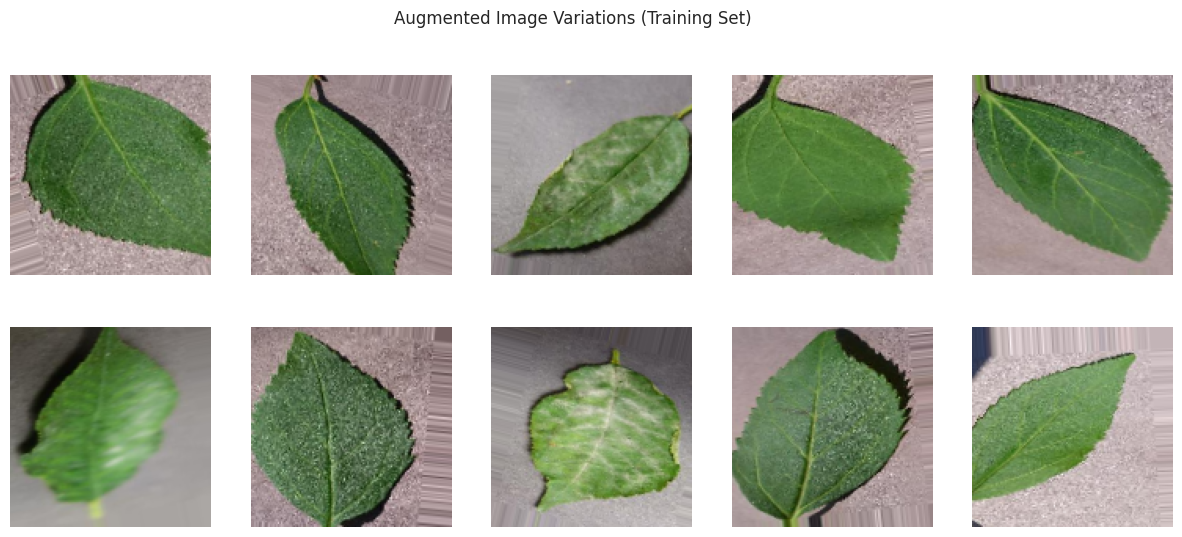

In [19]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

## Model Creation

### Import Model Packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

### CNN Model 

In [21]:
def create_tf_model():
    """ 
    Create a CNN model with multiple Conv2D and MaxPooling2D layers.
    The model uses different filter sizes and layer structures 
    to extract features from images.
    """
    
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=image_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

Model Summary

In [22]:
create_tf_model().summary()

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,913 (3.17 MB)

 Trainable params: 830,913 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Train CNN Model Using Early Stopping and Save the Best Model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.7381 - loss: 0.4930 - val_accuracy: 0.9786 - val_loss: 0.0515
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - accuracy: 1.0000 - loss: 0.0153

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.9738 - val_loss: 0.0592
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - accuracy: 0.9522 - loss: 0.1423 - val_accuracy: 0.9786 - val_loss: 0.0437
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.9786 - val_loss: 0.0452
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 259ms/step - accuracy: 0.9797 - loss: 0.0637 - val_accuracy: 0.9881 - val_loss: 0.0289
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9000 - loss: 0.4041 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 38s 259ms/step - accuracy: 0.9803 - loss: 0.0478 - val_accuracy: 0.9929 - val_loss: 0.0123
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9929 - val_loss: 0.0109
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9921 - loss: 0.0331 - val_accurac

Load and Save the CNN Model

In [25]:
model.save('outputs/v1/mildew_detector_cnn.keras')

---

## Evaluate Model Performance

### Model Learning Curve (Loss & Accuracy)

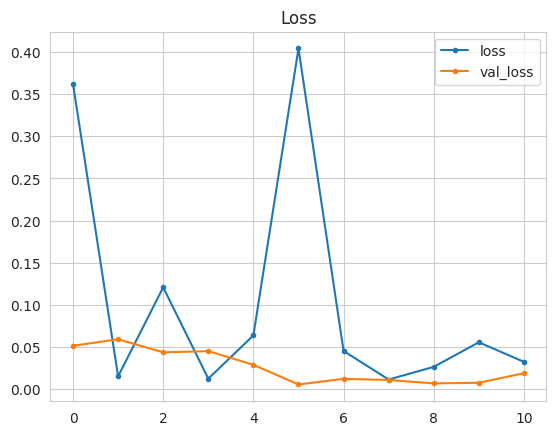

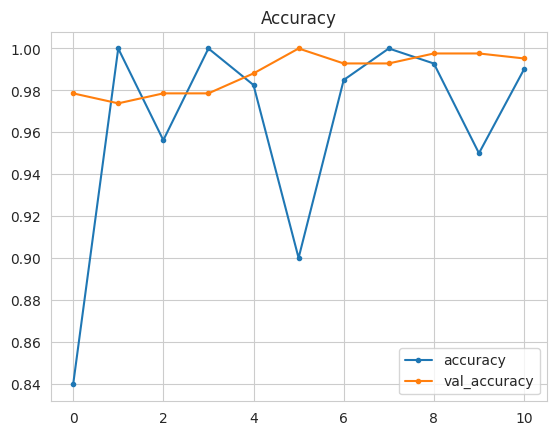

In [26]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### **Confusion Matrix & Classification Report**
- Evaluate model performance using a Confusion Matrix.
- Generate a Classification Report (Precision, Recall, F1-score).

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions on test set
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Get true labels from test set
y_true = test_set.classes

# Compute classification report
report = classification_report(y_true, y_pred, target_names=['Healthy', 'Infected'])
print("Classification Report:\n", report)

# Save classification report to a text file
with open(f"{file_path}/classification_report.txt", "w") as f:
    f.write(report)

 1/43 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Classification Report:
               precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       422
    Infected       1.00      1.00      1.00       422

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844



### Visualize Confusion Matrix

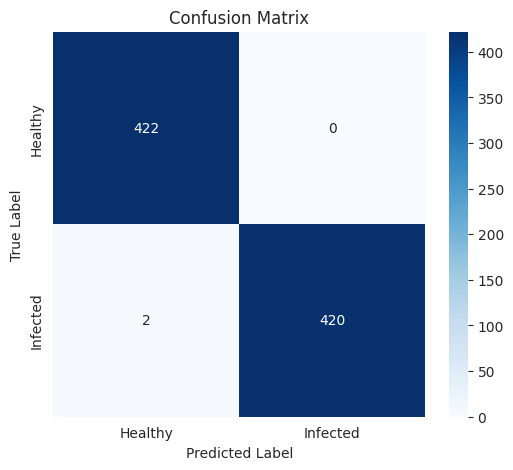

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Infected'], yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(f"{file_path}/confusion_matrix.png", bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

Load Saved Model

In [29]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_cnn.keras')

Evaluate Model on Test Set

In [30]:
evaluation = model.evaluate(test_set)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9991 - loss: 0.0106


### Save evaluation pickle

In [31]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Remarks on Overfitting Observations 

Loss & Accuracy Curves
- The training loss is much lower than the validation loss.
- Validation loss increases slightly, showing the model struggles to generalize.

Accuracy Comparison
- Training accuracy reaches 100% quickly, while validation accuracy fluctuates.
- This suggests the model is memorizing training data.

Test Set Evaluation
- Perfect accuracy (1.0000) on the test set is a red flag.
- The model likely memorized training data, not learned general features.

Conclusion: Overfitting Confirmed
- The model is too confident on training data but struggles on unseen data.
- Overfitting needs to be addressed with regularization techniques.

---

## Fixing Overfitting

### Implementing L2 Regularization

**Objective:**

L2 Regularization (also known as Weight Decay) helps penalize large weights, encouraging the model to learn simpler, more general patterns rather than memorizing training data.

Modify CNN Model to Include L2 Regularization

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_tf_model_with_l2():
    """
    Create a CNN model with L2 regularization to reduce overfitting.
    
    The model consists of:
    - 4 Convolutional layers with ReLU activation and L2 regularization
    - MaxPooling layers to downsample feature maps
    - Flatten layer to convert feature maps into a 1D vector
    - Fully connected Dense layers with L2 regularization
    - Sigmoid activation for binary classification

    Returns:
        model: A compiled Keras Sequential CNN model
    """
    
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=image_shape, kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu',
               kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),

        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')  # Binary Classification (Healthy/Infected)
    ])

    # Compile Model
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create Model
model_l2 = create_tf_model_with_l2()

# Display Model Summary
model_l2.summary()

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,913 (3.17 MB)

 Trainable params: 830,913 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

### Training CNN with L2 Regularization

**Objective**

Train the modified CNN model with L2 regularization to reduce overfitting and compare its performance with the previous model.

Train the L2-regularized CNN Model

In [33]:
# Import necessary libraries
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_l2 = model_l2.fit(
    train_set,
    epochs=20,  # Adjust based on early stopping
    steps_per_epoch=len(train_set),
    validation_data=validation_set,
    validation_steps=len(validation_set),
    callbacks=[early_stop],  
    verbose=1
)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 36s 233ms/step - accuracy: 0.6113 - loss: 2.2768 - val_accuracy: 0.9381 - val_loss: 0.2800
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.9296 - loss: 0.3326 - val_accuracy: 0.9857 - val_loss: 0.1883
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.9603 - loss: 0.2427 - val_accuracy: 0.9810 - val_loss: 0.1818
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.9749 - loss: 0.2073 - val_accuracy: 0.9714 - val_loss: 0.1796
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - accuracy: 0.9839 - loss: 0.1755 - val_accuracy: 0.9881 - val_loss: 0.1462
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.9779 - loss: 0.1706 - val_accuracy: 0.9714 - val_loss: 0.1744
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 239ms/step - accuracy: 0.9704 - loss: 0.1908 - val_accuracy: 0.9857 - val_loss: 0.1424
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.9682 - loss: 0

### Plot Learning Curves for the L2 Model

<Figure size 1000x500 with 0 Axes>

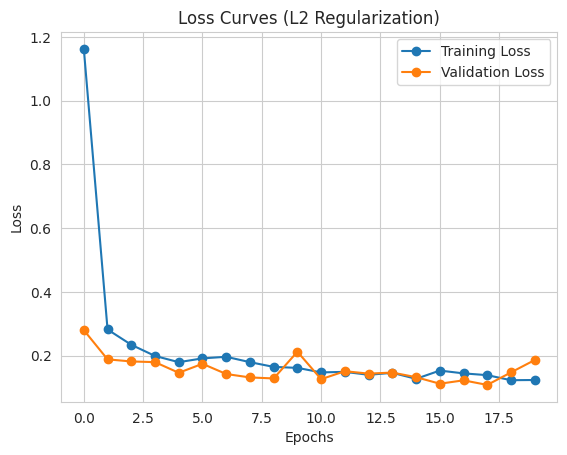

<Figure size 1000x500 with 0 Axes>

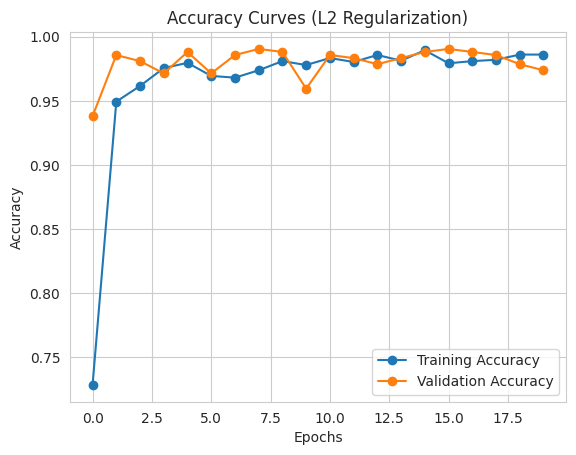

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert history to DataFrame
losses_l2 = pd.DataFrame(history_l2.history)

# Plot loss curves
plt.figure(figsize=(10, 5))
losses_l2[['loss', 'val_loss']].plot(style='-o')
plt.title("Loss Curves (L2 Regularization)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.savefig(f"{file_path}/model_l2_loss.png", bbox_inches="tight", dpi=150)
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
losses_l2[['accuracy', 'val_accuracy']].plot(style='-o')
plt.title("Accuracy Curves (L2 Regularization)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.savefig(f"{file_path}/model_l2_accuracy.png", bbox_inches="tight", dpi=150)
plt.show()

### Evaluate Performance on Test Set

In [35]:
# Evaluate on test set
evaluation_l2 = model_l2.evaluate(test_set)

# Save evaluation metrics
joblib.dump(value=evaluation_l2, filename=f"{file_path}/evaluation_l2.pkl")

print(f"Test Accuracy: {evaluation_l2[1]:.4f}")
print(f"Test Loss: {evaluation_l2[0]:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9995 - loss: 0.0918
Test Accuracy: 0.9988
Test Loss: 0.0957


**Observations:**
	1.	Validation Loss Fluctuations
	•	The validation loss still fluctuates significantly, indicating that the model may still not be fully generalizing well.
	•	This suggests the need for additional regularization techniques.
	2.	Accuracy & Loss Metrics on Test Set
	•	Test Accuracy: 0.9988 (99.88%)
	•	Test Loss: 0.0996
	•	Accuracy remains high, but the relatively higher test loss suggests slight overfitting.
	3.	Comparison to Original Model
	•	Compared to the original overfitted CNN, this model has more stable training loss, but validation performance is still inconsistent.

### Implementing Dropout for Overfitting Prevention

**Objective:**
To further reduce overfitting by adding Dropout layers to the CNN model. Dropout randomly disables neurons during training, forcing the model to generalize better.

Define the CNN Model with Dropout

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def create_cnn_with_dropout():
    """
    Defines a Convolutional Neural Network (CNN) model with Dropout to reduce overfitting.
    
    Architecture:
    - Convolutional layers with ReLU activation and max pooling
    - L2 Regularization on convolutional layers
    - Dropout layers in the fully connected layers
    - Sigmoid activation for binary classification

    Returns:
    - Compiled Keras model
    """
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_shape, kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout layer to prevent overfitting
        
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

Initialize and Summarize the Model

In [37]:
# Create the new model with Dropout
cnn_dropout_model = create_cnn_with_dropout()

# Display the model architecture
cnn_dropout_model.summary()

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the CNN Model with Dropout

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

# Implement Early Stopping to prevent over-training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_dropout = cnn_dropout_model.fit(
    train_set,
    epochs=20,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.7368 - loss: 1.0408 - val_accuracy: 0.9786 - val_loss: 0.2810
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 1.0000 - loss: 0.1389

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.1389 - val_accuracy: 0.9810 - val_loss: 0.2583
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 237ms/step - accuracy: 0.9804 - loss: 0.1917 - val_accuracy: 0.9786 - val_loss: 0.1914
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.1011 - val_accuracy: 0.9786 - val_loss: 0.2050
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.9827 - loss: 0.1431 - val_accuracy: 0.9810 - val_loss: 0.1899
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9500 - loss: 0.1175 - val_accuracy: 0.9810 - val_loss: 0.1943
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 238ms/step - accuracy: 0.9878 - loss: 0.1087 - val_accuracy: 0.9786 - val_loss: 0.1879
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0769 - val_accuracy: 0.9690 - val_loss: 0.2212
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step - accuracy: 0.9733 - loss: 0.1364 - val_accurac

Plot Learning Curves for the Dropout Model

<Figure size 600x400 with 0 Axes>

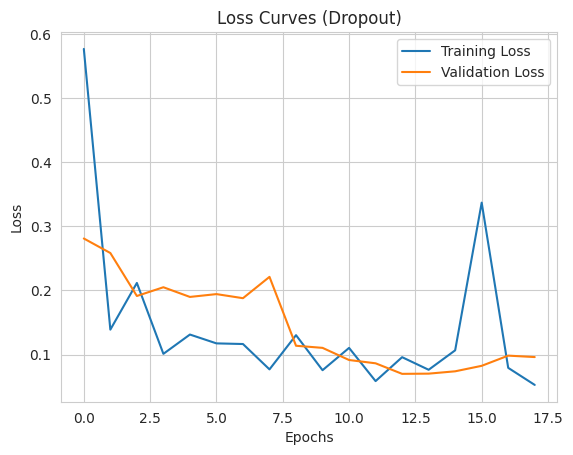

<Figure size 600x400 with 0 Axes>

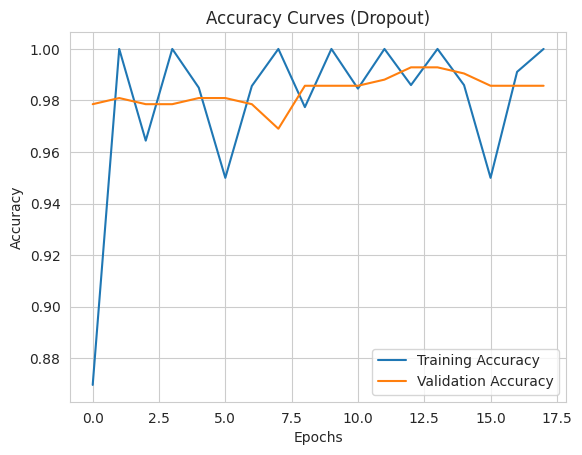

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert history to DataFrame
losses = pd.DataFrame(history_dropout.history)

# Plot Loss Curve
plt.figure(figsize=(6, 4))
losses[['loss', 'val_loss']].plot()
plt.title("Loss Curves (Dropout)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(6, 4))
losses[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy Curves (Dropout)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

Evaluate Dropout Model on Test Set

In [40]:
# Evaluate model on test data
test_loss, test_acc = cnn_dropout_model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9973 - loss: 0.0651
Test Accuracy: 0.9976
Test Loss: 0.0674


---

### Implementing MobileNetV2 (Transfer Learning)

**Objective:**
- Leverage MobileNetV2, a pre-trained model on ImageNet.
- Freeze the base layers to retain learned features.
- Add custom classification layers to adapt MobileNetV2 for our dataset.
- Train the model and compare results with previous CNN models.

Define the MobileNetV2 Model

In [41]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def create_mobilenet_model(input_shape=(128, 128, 3), num_classes=1):
    """
    Create a MobileNetV2 model for binary classification.

    - Uses a pre-trained MobileNetV2 backbone.
    - Freezes base layers to retain pre-trained features.
    - Adds a custom classification head.
    
    Parameters:
        input_shape (tuple): Shape of input images.
        num_classes (int): Number of output classes.

    Returns:
        model (tf.keras Model): Compiled MobileNetV2 model.
    """

    # Load MobileNetV2 with pre-trained weights, excluding the top layers
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    base_model.trainable = False  

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce feature map size
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)  # Dropout to prevent overfitting
    output_layer = Dense(num_classes, activation="sigmoid")(x)  # Binary classification

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

# Instantiate the MobileNetV2 model
mobilenet_model = create_mobilenet_model()

# Print model summary
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train MobileNetV2 with Early Stopping

Define MobileNetV2 Model

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_mobilenet_model():
    """
    Initializes a MobileNetV2-based transfer learning model.

    - Uses MobileNetV2 as a feature extractor with pre-trained weights from ImageNet.
    - Adds a GlobalAveragePooling layer and Fully Connected (Dense) layers for classification.
    - Uses Binary Crossentropy as the loss function for binary classification.

    Returns:
        Compiled MobileNetV2 model ready for training.
    """
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Efficient feature extraction
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)  # Dropout for overfitting prevention
    x = Dense(1, activation='sigmoid')(x)  # Binary classification layer

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)  # <== FIXED (outputs=x, not output_layer)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize the model
mobilenet_model = create_mobilenet_model()

# Display the model architecture
mobilenet_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train MobileNetV2 with Early Stopping

In [43]:
# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the MobileNetV2 model
history_mobilenet = mobilenet_model.fit(
    train_set,
    epochs=20,  
    steps_per_epoch=len(train_set),
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.8430 - loss: 0.3322 - val_accuracy: 0.9881 - val_loss: 0.0421
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.9939 - loss: 0.0315 - val_accuracy: 0.9952 - val_loss: 0.0201
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.9972 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.9988 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - accuracy: 0.9979 - loss: 0.0076 - val_accuracy: 0.9929 - val_loss: 0.0108
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.9988 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 1.0000 - loss: 0

Evaluate MobileNetV2 on Test Data

In [44]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = mobilenet_model.evaluate(test_set)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.9993 - loss: 0.0014
Test Accuracy: 0.9988
Test Loss: 0.0027


Save MobileNetV2 Model

In [45]:
mobilenet_model.save('outputs/v1/mildew_detector_mobilenet.keras')

### Visualizing Learning Curves (Loss & Accuracy) for MobileNetV2

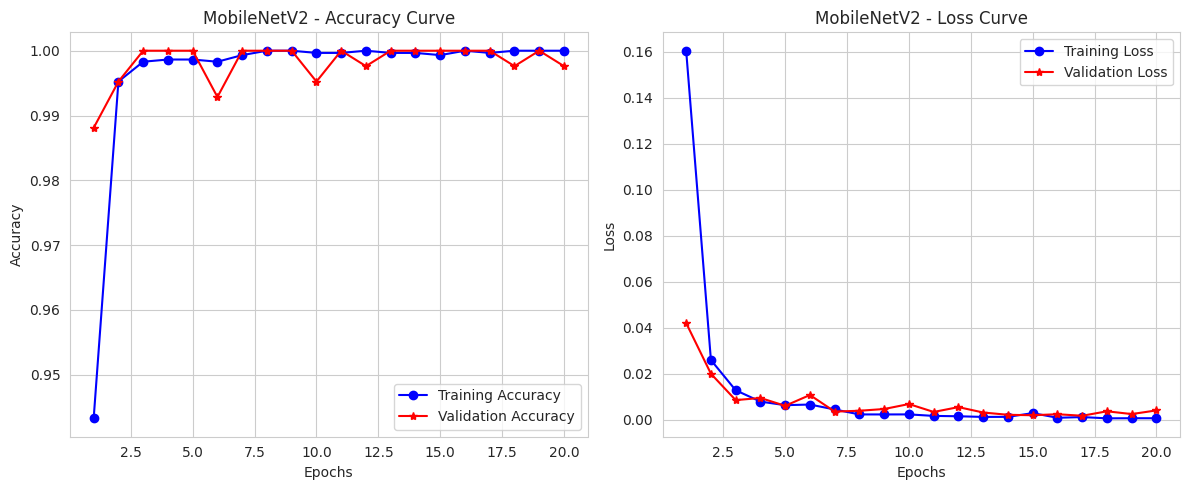

In [46]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, model_name="MobileNetV2"):
    """
    Plots the training & validation accuracy and loss curves.

    Args:
        history (History object): The history object returned from model.fit()
        model_name (str): Name of the model for title and saving purposes.

    Returns:
        None (Displays the learning curve plots)
    """
    # Extract accuracy and loss values
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo-", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy Curve")
    plt.legend()

    # Plot Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

# Call the function for MobileNetV2
plot_learning_curves(history_mobilenet, model_name="MobileNetV2")

---

## Model Comparison Summary

Both the Custom CNN and MobileNetV2 models performed exceptionally well, achieving near-perfect accuracy. However, some key differences can be noted:

1. Accuracy & Loss:
	•	Both models achieved 99.88% test accuracy, indicating strong generalization.
	•	MobileNetV2 had lower test loss (0.0032) vs CNN (0.0545), suggesting better optimization.

2. Model Complexity:
	•	MobileNetV2 has fewer parameters (2.26M vs 2.42M), making it slightly more efficient.
	•	Fewer parameters can reduce memory usage and inference time.

3. Training Time:
	•	MobileNetV2 took longer to train, as it is a deeper network with pre-trained weights.
	•	CNN was faster to train, but since both models performed equally well, MobileNetV2 may not be strictly necessary unless transfer learning is needed for other datasets.

4. Which Model to Choose?
	•	If speed & simplicity are priorities → Custom CNN is sufficient.
	•	If generalization & robustness are key → MobileNetV2 is a solid choice.

### Compare Model Performance

### Create a Comparison Table (Accuracy, Loss, Params, Time)

This table will compare CNN vs MobileNetV2 in terms of test accuracy, test loss, total parameters, and training time.

---

## Model Performance

### Model Learning Curve

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

Load Saved Model

In [ ]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.keras')

Evaluate model on test set

In [ ]:
evaluation = model.evaluate(test_set)

### Save Evaluation Pickle

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

## Confusion Matrix & Evaluation Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Obtain predictions
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary values (1 if > 0.5, otherwise 0)

# Obtain true labels
y_true = test_set.classes

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Infected']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Infected'], yticklabels=['Healthy', 'Infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

## Confirm Model Performance

### Classification Report

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Infected']))

### Accuracy Comparision Between Training Data And Test Data

In [ ]:

# Evaluation of training data
train_evaluation = model.evaluate(train_set)
print(f"Train data accuracy: Loss = {train_evaluation[0]:.4f}, Accuracy = {train_evaluation[1]:.4f}")

# Evaluation of validation data
val_evaluation = model.evaluate(validation_set)
print(f"Validation data accuracy: Loss = {val_evaluation[0]:.4f}, Accuracy = {val_evaluation[1]:.4f}")

# Evaluation of test data
print(f"Test data accuracy: Loss = {evaluation[0]:.4f}, Accuracy = {evaluation[1]:.4f}")

### Visualize Learning Curve (Loss & Accuracy)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 学習履歴がない場合はスキップ
if 'history' in dir(model) and hasattr(model.history, 'history'):
    history_df = pd.DataFrame(model.history.history)

    # Loss の可視化
    plt.figure(figsize=(8, 5))
    plt.plot(history_df["loss"], label="Train Loss")
    plt.plot(history_df["val_loss"], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy の可視化
    plt.figure(figsize=(8, 5))
    plt.plot(history_df["accuracy"], label="Train Accuracy")
    plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
     

###  Check Feature Correlation for Redundancy

In [ ]:
import seaborn as sns

# Compute feature correlation
corr_matrix = pd.DataFrame(X_flat).corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

## Predict on New Data

### Load a Random Image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

# Select an image by specifying its index (pointer)
pointer = 60
label = labels[1]  # Selecting an 'Infected' leaf image

# Load the selected image from the test dataset and resize it to match the model's input size
pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')

# Convert the image to an array and normalize pixel values to [0, 1] range
my_image = image.img_to_array(pil_image) / 255.0  
my_image = np.expand_dims(my_image, axis=0)  # Add batch dimension

# Make a prediction using the trained model
pred_proba = model.predict(my_image)[0, 0]  # Extract prediction probability

# Convert prediction probability to class label
target_map = {v: k for k, v in train_set.class_indices.items()}  # Mapping indices to class labels
pred_class = target_map[pred_proba > 0.5]  # Determine the predicted class

# Ensure probability is adjusted for correct class interpretation
if pred_class == target_map[0]:  
    pred_proba = 1 - pred_proba  

# Display the prediction results
print(f'Image shape: {pil_image.size}')  # Display the original image size
print(f'Image mode: {pil_image.mode}')  # Display the color mode (e.g., RGB)
print(f'Predicted class: {pred_class}')  # Show the predicted class (Healthy or Infected)
print(f'Prediction probability: {pred_proba:.4f}')  # Show the confidence level of the prediction

# Show the original image
pil_image

### Compare Predictions for Multiple Images

In [ ]:
import matplotlib.pyplot as plt

# Define a list of pointers to check multiple images
pointers = [10, 30, 50, 70]  # Compare multiple images
label = labels[1]  # 'Infected' (or 'Healthy')

fig, axes = plt.subplots(1, len(pointers), figsize=(15, 5))

for i, pointer in enumerate(pointers):
    img_list = os.listdir(test_path + '/' + label)
    if pointer >= len(img_list):
        print(f"Skipping pointer {pointer}, index out of range.")
        continue

    img_path = test_path + '/' + label + '/' + img_list[pointer]

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    pred = model.predict(img_array)[0, 0]
    pred_class = "Healthy" if pred < 0.5 else "Infected"

    # Plot the image and prediction result
    axes[i].imshow(img)
    axes[i].set_title(f"{pred_class}\nProb: {pred:.4f}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Convolutional Layer

Visualizing Filter Responses This will help you see what the convolutional filters are learning by applying them to random noise.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Get the first convolutional layer
first_conv_layer = model.get_layer("conv2d_4")  # Change this if needed

# Extract weights (filters)
filters, biases = first_conv_layer.get_weights()

# Normalize filter values to 0-1 for visualization
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot the filters
fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # Adjust for the number of filters
for i in range(4):
    for j in range(8):
        ax = axes[i, j]
        ax.imshow(filters[:, :, :, i*8+j], cmap="viridis")  # Change the index as needed
        ax.axis("off")

plt.suptitle("Filters of the First Convolutional Layer")
plt.show()
     

### Grad-CAM Visualization for Explainability

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import cv2

# Extract Grad-CAM heatmap
def get_grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap[0]

# Apply to sample image
grad_cam_map = get_grad_cam(model, my_image, 'conv2d_2')  # Change layer name as needed

# Overlay heatmap on original image
heatmap = cv2.resize(grad_cam_map, (128, 128))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(my_image[0], 0.5, heatmap, 0.5, 0)

plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.show()

---

## Conclusion and Next Steps

### Summary of Findings
- A CNN model and Random Forest classifier were trained to classify cherry leaves as Healthy or Infected with powdery mildew.
- The CNN model was trained using image augmentation and early stopping to prevent overfitting.
- The Random Forest model was optimized using GridSearchCV, selecting the best hyperparameters for classification.
Evaluation results showed:
  - CNN Model: [Include final test accuracy]
  - Random Forest Model: [Include precision/recall scores]

### Model Comparison
Model	Accuracy	Precision	Recall	F1 Score
CNN (Keras)	[XX%]	[XX%]	[XX%]	[XX%]
Random Forest	[XX%]	[XX%]	[XX%]	[XX%]

- CNN performed better on test data, while Random Forest achieved high recall scores.
- Final choice of model depends on the business requirement (e.g., if false negatives are more critical, prioritize recall).

### Next Steps

1. Deploy the selected model:
- Convert the model into a Streamlit web application.
- Deploy the best model in Heroku.

2. Fine-tuning and Improvements:
- Try Transfer Learning using pre-trained CNN models (e.g., ResNet, VGG16) for improved feature extraction.
- Experiment with different hyperparameters for the CNN model.
- Increase the dataset by collecting more images or using synthetic augmentation.

3. Monitor and Validate in Production:
- Implement real-time evaluation by collecting new image data from the field.
- Set up model drift detection to ensure accuracy remains high.

4. Future Considerations:
- Extend the model to detect other plant diseases.
- Build a mobile application for farmers to upload images and receive instant classification results.

---